<a href="https://colab.research.google.com/github/armandossrecife/piloto/blob/main/testes_issues_jira_e_msg_commits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependências



In [ ]:
!pip install jira > install_jira.log
!pip install sqlite3 > install_sqlite.log
!sudo apt install sqlite3 > install_sqlite3.log

In [ ]:

print('Install dependencies...')
print('Update apt. ')
!sudo apt update > apt_update.log
print('Install software-properties-common.')
!sudo apt install software-properties-common > spc.log
print('Add ppa-git-core repository.')
!sudo add-apt-repository -y ppa:git-core/ppa > ppa_git_core.log
print('Install the latest version of git.')
!sudo apt install -y git > install_git.log
!git --version > git_version.log
print('Install pydriller')
!pip3 install pydriller > install_pydriller.log
!pip3 list | grep PyDriller > versao_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')


Install dependencies...
Update apt. 


Install software-properties-common.


Add ppa-git-core repository.
Install the latest version of git.


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Install pydriller
Install gitpython.
Install Jira Python lib.
All depenpencies installed!
Details in install.log


# Apoio (Classes)

In [ ]:
from jira import JIRA
import os
from datetime import datetime, timedelta
import tqdm
import sqlite3
import subprocess
import sqlite3

JIRA_SERVER = 'https://issues.apache.org/jira'
DATABASE_NAME = "issues_db.db"

os.environ['DATABASE_NAME'] = DATABASE_NAME
# Credentials
os.environ['USERNAME'] = '?'
os.environ['PASSWORD'] = '?'
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments

  def get_comments(self) -> dict:
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

class IssuesDatabase:
    def __init__(self, database_name):
        self.database_name = database_name
        self.create_tables()

    def create_tables(self):
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Issues (
                id INTEGER PRIMARY KEY,
                project TEXT,
                key TEXT,
                summary TEXT,
                issue_type TEXT,
                status TEXT,
                priority TEXT,
                description TEXT
            )
        ''')

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Comments (
                id INTEGER PRIMARY KEY,
                key TEXT,
                comment TEXT
            )
        ''')

        self.conn.commit()

    def insert_in_table_issues(self, project, key, summary, issue_type, status, priority, description):
        values = (None, project, key, summary, issue_type, status, priority, description)
        self.cursor.execute('''
            INSERT INTO Issues
            (id, project, key, summary, issue_type, status, priority, description)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', values)

        self.conn.commit()

    def insert_in_table_comments(self, key, comment):
        values = (None, key, comment)
        self.cursor.execute('''
            INSERT INTO Comments
            (id, key, comment)
            VALUES (?, ?, ?)
        ''', values)

        self.conn.commit()

    def show_content(self, table):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()
        for row in rows:
            print(row)

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def close_connection(self):
        self.conn.close()

# Cria uma instância para acessar o servidor Jira

In [ ]:
# Create a JIRA client instance
jira_instance = JIRA(server=JIRA_SERVER, basic_auth=(username, password))

jira_utilidades = JiraUtils(project='CASSANDRA', jira_instance=jira_instance)

# Coleta os issues do projeto Cassandra

In [ ]:
cassandra_block_issues_by_date_2009_2023 = jira_utilidades.get_list_of_block_issues_by_dates(date1=(2009,3,2), date2=(2023,9,12), distance=120)

Aguarde...


Progress Message Analysis:   2%|▏         | 1/45 [00:04<03:08,  4.28s/it]

Range: project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29", qtd issues: 263


Progress Message Analysis:   4%|▍         | 2/45 [00:08<02:54,  4.05s/it]

Range: project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27", qtd issues: 251


Progress Message Analysis:   7%|▋         | 3/45 [00:13<03:09,  4.51s/it]

Range: project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24", qtd issues: 310


Progress Message Analysis:   9%|▉         | 4/45 [00:34<07:35, 11.11s/it]

Range: project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24", qtd issues: 388


Progress Message Analysis:  11%|█         | 5/45 [00:40<06:08,  9.22s/it]

Range: project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22", qtd issues: 419


Progress Message Analysis:  13%|█▎        | 6/45 [00:48<05:39,  8.71s/it]

Range: project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19", qtd issues: 545


Progress Message Analysis:  16%|█▌        | 7/45 [00:55<05:19,  8.40s/it]

Range: project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19", qtd issues: 593


Progress Message Analysis:  18%|█▊        | 8/45 [01:03<04:56,  8.01s/it]

Range: project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17", qtd issues: 573


Progress Message Analysis:  20%|██        | 9/45 [01:10<04:42,  7.85s/it]

Range: project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14", qtd issues: 532


Progress Message Analysis:  22%|██▏       | 10/45 [01:15<04:09,  7.12s/it]

Range: project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13", qtd issues: 423


Progress Message Analysis:  24%|██▍       | 11/45 [01:22<03:55,  6.93s/it]

Range: project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11", qtd issues: 441


Progress Message Analysis:  27%|██▋       | 12/45 [01:28<03:36,  6.55s/it]

Range: project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08", qtd issues: 433


Progress Message Analysis:  29%|██▉       | 13/45 [01:33<03:17,  6.16s/it]

Range: project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08", qtd issues: 386


Progress Message Analysis:  31%|███       | 14/45 [01:40<03:20,  6.46s/it]

Range: project=CASSANDRA and created>="2013/06/09" and created<="2013/10/06", qtd issues: 522


Progress Message Analysis:  33%|███▎      | 15/45 [01:47<03:21,  6.73s/it]

Range: project=CASSANDRA and created>="2013/10/07" and created<="2014/02/03", qtd issues: 492


Progress Message Analysis:  36%|███▌      | 16/45 [01:56<03:35,  7.42s/it]

Range: project=CASSANDRA and created>="2014/02/04" and created<="2014/06/03", qtd issues: 690


Progress Message Analysis:  38%|███▊      | 17/45 [02:06<03:48,  8.15s/it]

Range: project=CASSANDRA and created>="2014/06/04" and created<="2014/10/01", qtd issues: 680


Progress Message Analysis:  40%|████      | 18/45 [02:15<03:44,  8.30s/it]

Range: project=CASSANDRA and created>="2014/10/02" and created<="2015/01/29", qtd issues: 655


Progress Message Analysis:  42%|████▏     | 19/45 [02:26<03:55,  9.04s/it]

Range: project=CASSANDRA and created>="2015/01/30" and created<="2015/05/29", qtd issues: 802


Progress Message Analysis:  44%|████▍     | 20/45 [02:37<04:02,  9.68s/it]

Range: project=CASSANDRA and created>="2015/05/30" and created<="2015/09/26", qtd issues: 875


Progress Message Analysis:  47%|████▋     | 21/45 [02:45<03:44,  9.35s/it]

Range: project=CASSANDRA and created>="2015/09/27" and created<="2016/01/24", qtd issues: 659


Progress Message Analysis:  49%|████▉     | 22/45 [02:55<03:32,  9.26s/it]

Range: project=CASSANDRA and created>="2016/01/25" and created<="2016/05/23", qtd issues: 769


Progress Message Analysis:  51%|█████     | 23/45 [03:05<03:34,  9.74s/it]

Range: project=CASSANDRA and created>="2016/05/24" and created<="2016/09/20", qtd issues: 787


Progress Message Analysis:  53%|█████▎    | 24/45 [03:11<03:00,  8.59s/it]

Range: project=CASSANDRA and created>="2016/09/21" and created<="2017/01/18", qtd issues: 453


Progress Message Analysis:  56%|█████▌    | 25/45 [03:17<02:32,  7.64s/it]

Range: project=CASSANDRA and created>="2017/01/19" and created<="2017/05/18", qtd issues: 403


Progress Message Analysis:  58%|█████▊    | 26/45 [03:22<02:11,  6.91s/it]

Range: project=CASSANDRA and created>="2017/05/19" and created<="2017/09/15", qtd issues: 338


Progress Message Analysis:  60%|██████    | 27/45 [03:26<01:51,  6.18s/it]

Range: project=CASSANDRA and created>="2017/09/16" and created<="2018/01/13", qtd issues: 282


Progress Message Analysis:  62%|██████▏   | 28/45 [03:30<01:34,  5.54s/it]

Range: project=CASSANDRA and created>="2018/01/14" and created<="2018/05/13", qtd issues: 277


Progress Message Analysis:  64%|██████▍   | 29/45 [03:35<01:22,  5.17s/it]

Range: project=CASSANDRA and created>="2018/05/14" and created<="2018/09/10", qtd issues: 265


Progress Message Analysis:  67%|██████▋   | 30/45 [03:39<01:11,  4.79s/it]

Range: project=CASSANDRA and created>="2018/09/11" and created<="2019/01/08", qtd issues: 250


Progress Message Analysis:  69%|██████▉   | 31/45 [03:41<00:56,  4.05s/it]

Range: project=CASSANDRA and created>="2019/01/09" and created<="2019/05/08", qtd issues: 143


Progress Message Analysis:  71%|███████   | 32/45 [03:44<00:49,  3.80s/it]

Range: project=CASSANDRA and created>="2019/05/09" and created<="2019/09/05", qtd issues: 177


Progress Message Analysis:  73%|███████▎  | 33/45 [03:47<00:42,  3.54s/it]

Range: project=CASSANDRA and created>="2019/09/06" and created<="2020/01/03", qtd issues: 164


Progress Message Analysis:  76%|███████▌  | 34/45 [03:54<00:48,  4.44s/it]

Range: project=CASSANDRA and created>="2020/01/04" and created<="2020/05/02", qtd issues: 306


Progress Message Analysis:  78%|███████▊  | 35/45 [03:58<00:44,  4.50s/it]

Range: project=CASSANDRA and created>="2020/05/03" and created<="2020/08/30", qtd issues: 300


Progress Message Analysis:  80%|████████  | 36/45 [04:03<00:40,  4.52s/it]

Range: project=CASSANDRA and created>="2020/08/31" and created<="2020/12/28", qtd issues: 284


Progress Message Analysis:  82%|████████▏ | 37/45 [04:07<00:35,  4.44s/it]

Range: project=CASSANDRA and created>="2020/12/29" and created<="2021/04/27", qtd issues: 262


Progress Message Analysis:  84%|████████▍ | 38/45 [04:11<00:29,  4.26s/it]

Range: project=CASSANDRA and created>="2021/04/28" and created<="2021/08/25", qtd issues: 244


Progress Message Analysis:  87%|████████▋ | 39/45 [04:16<00:26,  4.48s/it]

Range: project=CASSANDRA and created>="2021/08/26" and created<="2021/12/23", qtd issues: 342


Progress Message Analysis:  89%|████████▉ | 40/45 [04:21<00:23,  4.77s/it]

Range: project=CASSANDRA and created>="2021/12/24" and created<="2022/04/22", qtd issues: 340


Progress Message Analysis:  91%|█████████ | 41/45 [04:26<00:18,  4.63s/it]

Range: project=CASSANDRA and created>="2022/04/23" and created<="2022/08/20", qtd issues: 267


Progress Message Analysis:  93%|█████████▎| 42/45 [04:30<00:13,  4.58s/it]

Range: project=CASSANDRA and created>="2022/08/21" and created<="2022/12/18", qtd issues: 273


Progress Message Analysis:  96%|█████████▌| 43/45 [04:35<00:09,  4.70s/it]

Range: project=CASSANDRA and created>="2022/12/19" and created<="2023/04/17", qtd issues: 328


Progress Message Analysis:  98%|█████████▊| 44/45 [04:39<00:04,  4.56s/it]

Range: project=CASSANDRA and created>="2023/04/18" and created<="2023/08/15", qtd issues: 298


Progress Message Analysis: 100%|██████████| 45/45 [04:41<00:00,  6.25s/it]

Range: project=CASSANDRA and created>="2023/08/16" and created<="2023/12/13", qtd issues: 97
2023-09-17 18:01:17.136356
Tempo da consulta: 0:04:41.316361


In [ ]:
cassandra_issues_from_2009_to_2023 = jira_utilidades.concatenate_block_of_issues(block_of_issues=cassandra_block_issues_by_date_2009_2023)

Total de issues recuperados: 18581


## Popula um manipulador de Issues do Jira

In [ ]:
cassandra_issues = JiraIssues(project='Cassandra', issues=[])

print('Popula issues do Cassandra')
for i,issue in enumerate(cassandra_issues_from_2009_to_2023):
  dict_comments_issue = {}
  list_comments = []
  for comment in issue.fields.comment.comments:
    elemento = (comment.id, comment.body)
    list_comments.append(elemento)
  dict_comments_issue[issue.key] = list_comments
  # Cria um JiraIssue
  jira_issue = JiraIssue(key=issue.key, summary=issue.fields.summary, status=issue.fields.status, issue_type=issue.fields.issuetype,priority=issue.fields.priority,description=issue.fields.description, comments=dict_comments_issue)
  cassandra_issues.add_issue(jira_issue)
print(f'{len(cassandra_issues.get_issues())} issues populados com sucesso!')

Popula issues do Cassandra
18581 issues populados com sucesso!


In [ ]:
print('Mostra o conteúdo dos 10 primeiros issues...')
for i,each in enumerate(cassandra_issues.get_issues()):
  print(i+1, each)
  print(f'Description: {each.description}')
  for k,v in each.get_comments().items():
    print(k)
    print(f'Comments: {len(v)}')
    for j in v:
      print(j)
  if i==10:
    break

Mostra o conteúdo dos 10 primeiros issues...
1 Key: CASSANDRA-263, Summary: get_slice needs to support desc from last column, Type: Bug, Status: Resolved
Description: At the moment there's no way to ask for a slice starting with the last column and going desc
CASSANDRA-263
Comments: 7
('12724762', "Is the problem that you don't know what the last column is? Normally, an application should be able to insert a fake column that's always larger than any real columns. Do you think that's good enough?")
('12724766', 'Yes.\n\nI was thinking that we could have the "CF" format (w/ no ":") stand for "start w/ first if asc or last if desc."  Reading the last from the column index should be reasonably efficient, right?')
('12725251', 'Using the column index to start with the last column group is possible and is efficient. I am just wondering if it is a good idea to give empty starting column different meanings depending on the ordering.')
('12725254', "I'm open to alternative APIs, but that one ma

# Carrega os issues coletados em um banco (Sqlite)

In [ ]:
db = IssuesDatabase("issues_db.db")
print('Popula o banco de dados issues_db...')
total_items = len(cassandra_issues.get_issues())
i = 0
iterable_cassandra_issues = tqdm.tqdm(cassandra_issues.get_issues(), total=total_items)
for each_jira_issue in iterable_cassandra_issues:
  db.insert_in_table_issues("CASSANDRA", each_jira_issue.key, each_jira_issue.summary, str(each_jira_issue.issue_type), str(each_jira_issue.status), str(each_jira_issue.priority), each_jira_issue.description)
  if len(each_jira_issue.get_comments().keys()) > 0:
    for issue_id,comments in each_jira_issue.get_comments().items():
      if len(comments) > 0:
        for comment in comments:
          if len(comment) > 0:
            elemento = comment[0] + ': ' + comment[1]
            db.insert_in_table_comments(issue_id, elemento)
  percentage = (i + 1) / total_items * 100
  iterable_cassandra_issues.set_description(f"Progress inserting data")
  i += 1
db.close_connection()
print('Banco issues_db carregado com sucesso!')

Popula o banco de dados issues_db...


Progress inserting data:  14%|█▎        | 2511/18581 [03:32<29:45,  9.00it/s]

In [ ]:
!ls -liath

total 101M
2752518 drwxr-xr-x 1 root root 4.0K Sep 17 18:27 .
6160941 -rw-r--r-- 1 root root 101M Sep 17 18:27 issues_db.db
6160744 -rw-r--r-- 1 root root  12K Sep 17 17:55 install.log
6160740 -rw-r--r-- 1 root root 1.4K Sep 17 17:55 install_jira_python.log
6160739 -rw-r--r-- 1 root root  341 Sep 17 17:55 install_gitpython.log
6160699 -rw-r--r-- 1 root root   39 Sep 17 17:55 versao_pydriller.log
6160626 -rw-r--r-- 1 root root 1.4K Sep 17 17:55 install_pydriller.log
6160619 -rw-r--r-- 1 root root   19 Sep 17 17:55 git_version.log
6160736 -rw-r--r-- 1 root root 1.9K Sep 17 17:55 install_git.log
6160703 -rw-r--r-- 1 root root 1.7K Sep 17 17:55 ppa_git_core.log
6160700 -rw-r--r-- 1 root root  216 Sep 17 17:54 spc.log
6160613 -rw-r--r-- 1 root root 1.5K Sep 17 17:54 apt_update.log
6160446 -rw-r--r-- 1 root root 1.4K Sep 17 17:54 install_sqlite3.log
6160414 -rw-r--r-- 1 root root    0 Sep 17 17:54 install_sqlite.log
6160442 -rw-r--r-- 1 root root 1.8K Sep 17 17:54 install_jira.log
6160395 dr

## Mostra um fragmento das tabelas Issues e Comments

In [ ]:
db = IssuesDatabase("issues_db.db")
db.show_n_lines(table='Issues', n=10)

(1, 'CASSANDRA', 'CASSANDRA-263', 'get_slice needs to support desc from last column', 'Bug', 'Resolved', 'Normal', "At the moment there's no way to ask for a slice starting with the last column and going desc")
(2, 'CASSANDRA', 'CASSANDRA-262', 'get_slice needs to allow returning all columns', 'Bug', 'Resolved', 'Normal', "Right now get_slice requires you to enter a 'large' value, -1 used to indicate 'all columns'. We should allow this.")
(3, 'CASSANDRA', 'CASSANDRA-261', 'get_slice needs offset + limit', 'Bug', 'Resolved', 'Normal', 'Right now get_slice does not allow you to provide an offset.  This would help for pagination.')
(4, 'CASSANDRA', 'CASSANDRA-260', 'Unable to read all columns in a column family from the CLI', 'Bug', 'Resolved', 'Normal', 'Since r788516 the typical \'get all columns for a row/cf\' example no longer works.\n\ncassandra> get Table1.Standard1[\'jsmith\']\nis the example from the wiki.\n\nThis is due to Table.getSliceFrom now requiring the cfName be split by "

In [ ]:
db.show_n_lines(table='Comments', n=10)

(1, 'CASSANDRA-263', "12724762: Is the problem that you don't know what the last column is? Normally, an application should be able to insert a fake column that's always larger than any real columns. Do you think that's good enough?")
(2, 'CASSANDRA-263', '12724766: Yes.\n\nI was thinking that we could have the "CF" format (w/ no ":") stand for "start w/ first if asc or last if desc."  Reading the last from the column index should be reasonably efficient, right?')
(3, 'CASSANDRA-263', '12725251: Using the column index to start with the last column group is possible and is efficient. I am just wondering if it is a good idea to give empty starting column different meanings depending on the ordering.')
(4, 'CASSANDRA-263', "12725254: I'm open to alternative APIs, but that one makes sense to me and doesn't require adding extra parameters :)")
(5, 'CASSANDRA-263', "12737354: Attach a fix. If startColumn is empty and isAscending is false, assume that we scan from the largest column in descen

# Extrai commits do repositório

In [ ]:
!git clone https://github.com/apache/cassandra.git

Cloning into 'cassandra'...
remote: Enumerating objects: 399110, done.
remote: Counting objects: 100% (2179/2179), done.
remote: Compressing objects: 100% (983/983), done.
remote: Total 399110 (delta 1001), reused 1830 (delta 849), pack-reused 396931
Receiving objects: 100% (399110/399110), 394.73 MiB | 19.36 MiB/s, done.
Resolving deltas: 100% (232968/232968), done.
Updating files: 100% (5913/5913), done.


In [ ]:
# Mostra todos os commits
!cd cassandra && git log --pretty="%H;%ai;%s" > all_commits_full.txt
!cd cassandra && git log --pretty="%H %s" > all_commits_msg.txt
!echo "10 primeiros commits all_commits_msg.txt"
!cd cassandra && head all_commits_msg.txt
!echo "..."

# Total de commits registrados entre as versões cassandra-3.0.0...cassandra-3.11.11
!echo "Total de commits registrados "
!cd cassandra && cat all_commits_msg.txt | wc -l

10 primeiros commits all_commits_msg.txt
3ebd09262ba2462e97b012838b19c6f3231d4190 Merge branch 'cassandra-5.0' into trunk
871e42cf97507f4536e4a4873cf4f8e9a68ff1a3 Merge branch 'cassandra-4.1' into cassandra-5.0
8bfe0e5878c64ed25591aae50643187bc8ab7241 InstanceClassLoader leak in 5.0/trunk
1087d88303754d52124c990b8d82640a729c8b9f Merge branch 'cassandra-5.0' into trunk
dcfacad116dc3e7fa63aff358b8edd4b5ac17e2f ninja fix unused import
f7472774f4c4e909af4a8a75c85ac5df71c71b63 Merge branch 'cassandra-5.0' into trunk
1ac31a64a9d02372f59938592aff283ed7c0b438 Merge branch 'cassandra-4.1' into cassandra-5.0
b8209a06fbad6d5dda239f06ea889a4a89427296 Merge branch 'cassandra-4.0' into cassandra-4.1
edde699a062701345133b6f0648a744b426a6f94 Merge branch 'cassandra-3.11' into cassandra-4.0
edf22ed776d36112c165c6858dd4866b754ecf34 Revert 18543 but retain properties
...
Total de commits registrados 
29166


In [ ]:
# Dados do 1o commit e do ultimo commit
!head /content/cassandra/all_commits_full.txt -n 1
!tail /content/cassandra/all_commits_full.txt -n 1

3ebd09262ba2462e97b012838b19c6f3231d4190;2023-09-15 14:12:28 -0600;Merge branch 'cassandra-5.0' into trunk
1f91e99223b0d1b7ed8390400d4a06ac08e4aa85;2009-03-02 07:57:22 +0000;git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@749218 13f79535-47bb-0310-9956-ffa450edef68


# Funções de apoio 2

In [ ]:
import re
import pandas as pd
import pydriller

In [ ]:
def find_cassandra_pattern(input_string):
    # Define the pattern using regular expression
    pattern = r'(CASSANDRA-\d+)'

    # Use re.search() to find the pattern in the input_string
    match = re.search(pattern, input_string)

    # If a match is found, return the matched pattern; otherwise, return None
    if match:
        return match.group(1)
    else:
        return None

# extrai o issue tracker salvo na mensagem de cada commit
def extract_cassandra_issue(text_content, project_id='CASSANDRA-'):
  """
  Extract the CASSANDRA-XYZ issue from the text.

  Args:
    text: The text to extract the issue from.

  Returns:
    The issue number, or None if the issue cannot be found.
  """

  issues_number = []

  lines = text_content.split('\n')
  for line in lines:
    issue_number = find_cassandra_pattern(line)
    if issue_number:
      issues_number.append(issue_number)
  return issues_number

def get_modified_files_from_commit(key):
  list_files = []
  MESSAGE = 0
  MODIFIED_FILES = 1
  QTD_MODIFIED_FILES = 2
  for each in key:
    if each in dict_commit_modified_files.keys():
      if dict_commit_modified_files[each] is not None:
        list_files.append(dict_commit_modified_files[each][MODIFIED_FILES])
  return list_files

### Analisa os issues que foram salvos em commits ###

def get_list_issues_number(commits_file_path='/content/cassandra/all_commits_msg.txt'):
  print('Gera a lista de issue number que aparece nas mensagens dos commits.')
  with open(commits_file_path, mode='r') as f_commits_msg:
    conteudo = f_commits_msg.read()

  list_issue_number = extract_cassandra_issue(text_content=conteudo, project_id='CASSANDRA-')

  clean_list_issue_number = []
  for each in list_issue_number:
    item = each.split()[0]
    item = item.replace(")", "")
    if item != 'CASSANDRA-' and item != 'CASSANDRA-CASSANDRA':
      clean_list_issue_number.append(item)

  return clean_list_issue_number

def get_list_cassandra_issues_analyzed(clean_list_issue_number):
  print('Gera a lista de issues analisados que aparecem nas mensagens dos commits')
  total_items = len(clean_list_issue_number)
  i = 0
  iterable_list_issue_number = tqdm.tqdm(clean_list_issue_number, total=total_items)
  # Faz a limpeza para garantir o id do Issue tracker
  list_cassandra_issues_analyzed = []
  for each in iterable_list_issue_number:
    list_cassandra_issues_analyzed.append(each)
    percentage = (i + 1) / total_items * 100
    iterable_list_issue_number.set_description(f"Progress Message Analysis")
    i += 1

  return list_cassandra_issues_analyzed

### Cria um Dataframe referente aos issues coletados ###

def generate_dict_all_issues(concatenated_list):
  dict_all_issues = {}

  list_key, list_summary, list_status, list_description, list_priority, list_timeestimate, list_timespent, list_issuetype = list(), list(), list(), list(), list(), list(), list(), list()

  i = 1
  for issue in concatenated_list:
      list_key.append(issue.key)
      list_summary.append(issue.fields.summary)
      list_status.append(issue.fields.status)
      list_description.append(issue.fields.description)
      list_priority.append(issue.fields.priority)
      list_timespent.append(issue.fields.timespent)
      list_timeestimate.append(issue.fields.timeestimate)
      list_issuetype.append(issue.fields.issuetype)
      i += 1

  dict_all_issues['key'] = list_key
  dict_all_issues['issue_type'] = list_issuetype
  dict_all_issues['summary'] = list_summary
  dict_all_issues['status'] = list_status
  dict_all_issues['description'] = list_description
  dict_all_issues['priority'] = list_priority
  dict_all_issues['timespent'] = list_timespent
  dict_all_issues['timeestimate'] = list_timeestimate

  return dict_all_issues

#!cd cassandra && git rev-list --count HEAD
def get_total_commit_count(repository_path):
    command = ["git", "rev-list", "--count", "HEAD"]
    result = subprocess.run(command, cwd=repository_path, stdout=subprocess.PIPE, text=True)
    total_commit_count = int(result.stdout.strip())
    return total_commit_count

### Gera os dicionários com commits e arquivos modificados ###
def extract_commits_info(total_commit_count):
  print('Extrai informações dos commits.')
  # 4. Extract Commit
  total_commits = total_commit_count
  dict_commit_modified_files = {}
  i = 0

  iterable_commits = tqdm.tqdm(pydriller.Repository("cassandra").traverse_commits(), total=total_commits)

  for commit in iterable_commits:
    list_modified_files = []
    for m in commit.modified_files:
      list_modified_files.append(m.filename)
    qtd_modified_files = len(list_modified_files)
    commit_message = commit.msg
    elemento = (commit_message, list_modified_files, qtd_modified_files)
    dict_commit_modified_files[commit.hash] = elemento
    percentage = (i + 1) / total_commits * 100
    iterable_commits.set_description(f"Progress Commit Analysis")
    i += 1

  return dict_commit_modified_files

def generate_dict_message_commits_valido(dict_commit_modified_files, list_cassandra_issues_analyzed):
  print('Gera o dicionário com issues em mensagens validas dos commits')
  dict_message_commits_valido = {}

  i = 0
  total_commits = len(dict_commit_modified_files)
  iterable_dict_commit_modified_files = tqdm.tqdm(dict_commit_modified_files.items(), total=total_commits)

  for k,v in iterable_dict_commit_modified_files:
    if v[0] is not None:
      for cassandra_issue in list_cassandra_issues_analyzed:
        if cassandra_issue != 'CASSANDRA-' and cassandra_issue in str(v[0]):
          dict_message_commits_valido[k] = cassandra_issue
          break
    percentage = (i + 1) / total_commits * 100
    iterable_dict_commit_modified_files.set_description(f"Progress Dict Message Commit Analysis")
    i += 1

  return dict_message_commits_valido

def generate_dict_key_commit_valido(lista_key_cassandra_all_issues, dict_message_commits_valido):
  print('Gera o dicionario de key commit valido')
  dict_key_commit_valido = {}
  list_commits_by_key = []

  i = 0
  j = 0
  total_issues = len(lista_key_cassandra_all_issues)
  iterable_lista_key_cassandra_all_issues = tqdm.tqdm(lista_key_cassandra_all_issues, total=total_issues)

  for each_issue in iterable_lista_key_cassandra_all_issues:
    list_commits_by_key = []
    for k,v in dict_message_commits_valido.items():
      if each_issue == v:
        i +=1
        list_commits_by_key.append(k)
    dict_key_commit_valido[each_issue] = list_commits_by_key
    percentage = (j + 1) / total_issues * 100
    iterable_lista_key_cassandra_all_issues.set_description(f"Progress Dict Key Commit Analysis")
    j += 1

  return dict_key_commit_valido

# Analisa os issues que foram salvos em commits

In [ ]:
clean_list_issue_number = get_list_issues_number()

Gera a lista de issue number que aparece nas mensagens dos commits.


In [ ]:
list_cassandra_issues_analyzed = get_list_cassandra_issues_analyzed(clean_list_issue_number)


Gera a lista de issues analisados que aparecem nas mensagens dos commits


Progress Message Analysis: 100%|██████████| 4734/4734 [00:10<00:00, 436.13it/s]


In [ ]:
print(f'{len(list_cassandra_issues_analyzed)} commits com Id de issue.')

4734 commits com Id de issue.


In [ ]:
# fragmento...
for i, each in enumerate(list_cassandra_issues_analyzed):
  print(i, each)
  if i==10:
    break

0 CASSANDRA-18772
1 CASSANDRA-18606
2 CASSANDRA-18745
3 CASSANDRA-18439
4 CASSANDRA-16905
5 CASSANDRA-16905
6 CASSANDRA-14227
7 CASSANDRA-18705
8 CASSANDRA-17687
9 CASSANDRA-18648
10 CASSANDRA-18329


# Coleta os issues do Servidor do Jira

In [ ]:
print(type(cassandra_issues_from_2009_to_2023))
print(len(cassandra_issues_from_2009_to_2023))

<class 'list'>
18581


In [ ]:
for i, each in enumerate(cassandra_issues_from_2009_to_2023):
  print(i, each)
  if i==5:
    break

0 CASSANDRA-263
1 CASSANDRA-262
2 CASSANDRA-261
3 CASSANDRA-260
4 CASSANDRA-259
5 CASSANDRA-258


# Cria um Dataframe referente aos issues coletados

In [ ]:
dict_all_issues = generate_dict_all_issues(cassandra_issues_from_2009_to_2023)
df_cassandra_all_issues = pd.DataFrame(dict_all_issues)
df_cassandra_all_issues

,key,issue_type,summary,status,description,priority,timespent,timeestimate
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,At the moment there's no way to ask for a slic...,Normal,NaN,NaN
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,Right now get_slice requires you to enter a 'l...,Normal,NaN,NaN
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,Right now get_slice does not allow you to prov...,Normal,NaN,NaN
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,Since r788516 the typical 'get all columns for...,Normal,NaN,NaN
4,CASSANDRA-259,New Feature,LRU cache for key positions,Resolved,"add cache like the old touch cache, but workin...",Normal,NaN,NaN
...,...,...,...,...,...,...,...,...
18576,CASSANDRA-18769,Bug,Fix flaky test: org.apache.cassandra.cql3.Memt...,Resolved,{noformat}\r\njava.lang.reflect.InaccessibleOb...,Normal,NaN,NaN
18577,CASSANDRA-18768,New Feature,Harry changes required for CEP-21 testing (NTS...,Triage Needed,None,Normal,NaN,NaN
18578,CASSANDRA-18767,Bug,tablestats should show speculative retries,Resolved,NodeProbe makes [provisions|https://github.com...,Normal,NaN,NaN
18579,CASSANDRA-18766,Bug,high speculative retries on v4.1.3,Open,There are up to 10+ times higher speculative r...,Normal,NaN,NaN


In [ ]:
lista_key_cassandra_all_issues = df_cassandra_all_issues.key.unique().tolist()
len(lista_key_cassandra_all_issues)

18581

# Gera os dicionários com commits e arquivos modificados

In [ ]:
repository_path = "cassandra"
total_commit_count = get_total_commit_count(repository_path)
print("Total number of commits:", total_commit_count)

Total number of commits: 29166


In [ ]:
dict_commit_modified_files = extract_commits_info(total_commit_count)

Extrai informações dos commits.


Progress Commit Analysis: 100%|██████████| 29166/29166 [06:20<00:00, 76.65it/s] 


In [ ]:
dict_message_commits_valido = generate_dict_message_commits_valido(dict_commit_modified_files, list_cassandra_issues_analyzed)

Gera o dicionário com issues em mensagens validas dos commits


Progress Dict Message Commit Analysis: 100%|██████████| 29166/29166 [02:00<00:00, 242.38it/s]


In [ ]:
dict_key_commit_valido = generate_dict_key_commit_valido(lista_key_cassandra_all_issues, dict_message_commits_valido)
len(dict_key_commit_valido)

Gera o dicionario de key commit valido


Progress Dict Key Commit Analysis: 100%|██████████| 18581/18581 [01:12<00:00, 255.10it/s]


18581

In [ ]:
key_commits_by_key = list(dict_key_commit_valido.keys() )
commits_commits_by_key = list(dict_key_commit_valido.values() )

dict_key_commit_valido_temp = {
    'key': key_commits_by_key,
    'commits': commits_commits_by_key
}

df_key_commit_valido = pd.DataFrame(data=dict_key_commit_valido_temp)
df_key_commit_valido

,key,commits
0,CASSANDRA-263,[9164940f41972e3611d1ad38a903ca39562e6feb]
1,CASSANDRA-262,[ef203cf00070fd719f87db9dd2384b8bc116ebd6]
2,CASSANDRA-261,[cdd8b170628176924c21db1cb6dcbecf4c7f2148]
3,CASSANDRA-260,[]
4,CASSANDRA-259,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013..."
...,...,...
18576,CASSANDRA-18769,[]
18577,CASSANDRA-18768,[]
18578,CASSANDRA-18767,[]
18579,CASSANDRA-18766,[]


In [ ]:
df_key_commit_valido['modified_files'] = df_key_commit_valido['commits'].apply(get_modified_files_from_commit)
df_cassandra_all_issues['commits'] = df_key_commit_valido['commits']
df_cassandra_all_issues['modified_files'] = df_key_commit_valido['modified_files']
df_cassandra_all_issues[['key', 'issue_type', 'commits', 'modified_files']]

,key,issue_type,commits,modified_files
0,CASSANDRA-263,Bug,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,[],[]
4,CASSANDRA-259,New Feature,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
...,...,...,...,...
18576,CASSANDRA-18769,Bug,[],[]
18577,CASSANDRA-18768,New Feature,[],[]
18578,CASSANDRA-18767,Bug,[],[]
18579,CASSANDRA-18766,Bug,[],[]


In [ ]:
df_cassandra_all_issues


,key,issue_type,summary,status,description,priority,timespent,timeestimate,commits,modified_files
0,CASSANDRA-263,Bug,get_slice needs to support desc from last column,Resolved,At the moment there's no way to ask for a slic...,Normal,NaN,NaN,[9164940f41972e3611d1ad38a903ca39562e6feb],"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,Bug,get_slice needs to allow returning all columns,Resolved,Right now get_slice requires you to enter a 'l...,Normal,NaN,NaN,[ef203cf00070fd719f87db9dd2384b8bc116ebd6],"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,Bug,get_slice needs offset + limit,Resolved,Right now get_slice does not allow you to prov...,Normal,NaN,NaN,[cdd8b170628176924c21db1cb6dcbecf4c7f2148],"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-260,Bug,Unable to read all columns in a column family ...,Resolved,Since r788516 the typical 'get all columns for...,Normal,NaN,NaN,[],[]
4,CASSANDRA-259,New Feature,LRU cache for key positions,Resolved,"add cache like the old touch cache, but workin...",Normal,NaN,NaN,"[26aefa2f4a04083c42f5338eda24a5bb09ab04ed, 013...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
...,...,...,...,...,...,...,...,...,...,...
18576,CASSANDRA-18769,Bug,Fix flaky test: org.apache.cassandra.cql3.Memt...,Resolved,{noformat}\r\njava.lang.reflect.InaccessibleOb...,Normal,NaN,NaN,[],[]
18577,CASSANDRA-18768,New Feature,Harry changes required for CEP-21 testing (NTS...,Triage Needed,None,Normal,NaN,NaN,[],[]
18578,CASSANDRA-18767,Bug,tablestats should show speculative retries,Resolved,NodeProbe makes [provisions|https://github.com...,Normal,NaN,NaN,[],[]
18579,CASSANDRA-18766,Bug,high speculative retries on v4.1.3,Open,There are up to 10+ times higher speculative r...,Normal,NaN,NaN,[],[]


# Faz a relação (ISSUES, COMMITs e Mensagens)

Issues do Jira que aparecem nas mensagens dos commits

In [ ]:
# @title
list_temp_key, list_temp_commits, list_temp_modified_files = list(), list(), list()

list_temp_commit_key = list()

for i in df_cassandra_all_issues.index:
  consulta_commits = df_cassandra_all_issues['commits'][i]
  if len(consulta_commits) > 0:
    for each_commit in consulta_commits:
      #print(df_cassandra_all_issues['key'][i], df_cassandra_all_issues['commits'][i], df_cassandra_all_issues['modified_files'][i])
      if df_cassandra_all_issues['key'][i] not in list_temp_key:
        list_temp_key.append(df_cassandra_all_issues['key'][i])
        commits_separated_by_commas = ",".join(df_cassandra_all_issues['commits'][i])
        list_temp_commits.append(commits_separated_by_commas)
        list_temp_modified_files.append(df_cassandra_all_issues['modified_files'][i])
        l_temp_commits = commits_separated_by_commas.split(',')
        for e in l_temp_commits:
          elemento = (e, df_cassandra_all_issues['key'][i])
          list_temp_commit_key.append(elemento)

dict_temp_2 = {
    'keys':list_temp_key, 'commits':list_temp_commits, 'modified_files':list_temp_modified_files
}

df_temp_2 = pd.DataFrame(dict_temp_2)
df_temp_2


,keys,commits,modified_files
0,CASSANDRA-263,9164940f41972e3611d1ad38a903ca39562e6feb,"[[Memtable.java, SSTableSliceIterator.java, Sl..."
1,CASSANDRA-262,ef203cf00070fd719f87db9dd2384b8bc116ebd6,"[[cassandra.thrift, Cassandra.java]]"
2,CASSANDRA-261,cdd8b170628176924c21db1cb6dcbecf4c7f2148,"[[cassandra.thrift, Cassandra.java, CliClient...."
3,CASSANDRA-259,"26aefa2f4a04083c42f5338eda24a5bb09ab04ed,013d5...","[[ColumnFamilyStore.java, SSTable.java], [stor..."
4,CASSANDRA-258,af82ca7ae16751641c051ef0ed7f76d01024d76e,"[[cassandra.thrift, Cassandra.java, CliClient...."
...,...,...,...
3205,CASSANDRA-18648,a9d1712aec0f26bb48bb6d084dc40121a296a2e0,[[CHANGES.txt]]
3206,CASSANDRA-18606,"1e2c88fff832d891b296165e9adda786182e850d,bf391...","[[Makefile, index.adoc, java_verify.result, na..."
3207,CASSANDRA-18550,"aafb4d19448f12ce600dc4e84a5b181308825b32,d2f6b...","[[CHANGES.txt, cassandra.yaml, DatabaseDescrip..."
3208,CASSANDRA-18511,"43ec1843918aba9e81d3c2dc1433a1ef4740a51f,91448...","[[build-resolver.xml, build.xml, GCInspector.j..."


In [ ]:
repository_commits = dict_commit_modified_files.keys()

In [ ]:
# Extract modified files from each commit
#modified_files = [(commit.hash, file) for commit in repository_commits for file in commit.modifications]
modified_files = []
for k, v in dict_commit_modified_files.items():
  for each in v[1]:
    elemento = (k, each)
    modified_files.append(elemento)


In [ ]:
# Assuming you have a function to extract the issues mentioned in commits
#commit_issues = extract_issues_mentioned_in_commits(repository_commits, issues)
commit_issues = list_temp_commit_key

In [ ]:

# Create a Pandas DataFrame for further analysis
commit_df = pd.DataFrame(modified_files, columns=['CommitHash', 'ModifiedFile'])
issue_df = pd.DataFrame(commit_issues, columns=['CommitHash', 'IssueID'])

In [ ]:
commit_df

,CommitHash,ModifiedFile
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,JSAP-2.1.jar
1,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,activation.jar
2,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.6.jar
3,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-2.7.7.jar
4,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,antlr-3.0.1.jar
...,...,...
98824,15f355a0062148e1ca511e8fc515e0cba380790d,SSTableLoaderTest.java
98825,edf22ed776d36112c165c6858dd4866b754ecf34,CHANGES.txt
98826,edf22ed776d36112c165c6858dd4866b754ecf34,Gossiper.java
98827,dcfacad116dc3e7fa63aff358b8edd4b5ac17e2f,Gossiper.java


In [ ]:
issue_df

,CommitHash,IssueID
0,9164940f41972e3611d1ad38a903ca39562e6feb,CASSANDRA-263
1,ef203cf00070fd719f87db9dd2384b8bc116ebd6,CASSANDRA-262
2,cdd8b170628176924c21db1cb6dcbecf4c7f2148,CASSANDRA-261
3,26aefa2f4a04083c42f5338eda24a5bb09ab04ed,CASSANDRA-259
4,013d59fc00d7d241abdf5bc0448ce55425c5f112,CASSANDRA-259
...,...,...
10328,22d74c711658507addfd67e2c78b04a9b88413b2,CASSANDRA-18550
10329,01726747cc7a74344f83d14bf52e31d95d13eb5a,CASSANDRA-18550
10330,43ec1843918aba9e81d3c2dc1433a1ef4740a51f,CASSANDRA-18511
10331,914484dfd86d5145118032a61c04bc3cdb632fb3,CASSANDRA-18511


In [ ]:
# 6. Correlation Analysis
# Group by files and count how many times each file appears in issues
file_issue_counts = issue_df['IssueID'].groupby(issue_df['CommitHash']).count().reset_index()

In [ ]:
# Merge with commit data
merged_data = pd.merge(commit_df, file_issue_counts, on='CommitHash', how='left')

In [ ]:
# Create a table showing files and the number of times they appeared in issues
file_issue_summary = merged_data.groupby('ModifiedFile')['IssueID'].sum().reset_index()
file_issue_summary.rename(columns={'IssueID': 'TimesAppearedInIssues'}, inplace=True)

In [ ]:
file_issue_summary.sort_values(by='TimesAppearedInIssues', ascending=False).head(50)

,ModifiedFile,TimesAppearedInIssues
683,CHANGES.txt,5685.0
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
6459,build.xml,601.0
6633,cassandra.yaml,477.0
3649,NEWS.txt,475.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
1251,CompactionManager.java,406.0


In [ ]:
file_issue_summary[file_issue_summary['ModifiedFile'].str.contains(".java")].sort_values(by='TimesAppearedInIssues', ascending=False)

,ModifiedFile,TimesAppearedInIssues
5476,StorageService.java,967.0
1076,ColumnFamilyStore.java,832.0
1603,DatabaseDescriptor.java,659.0
5473,StorageProxy.java,463.0
838,CassandraServer.java,410.0
...,...,...
3347,MapSerializerTest.java,0.0
3378,MaterializedViewUtils.java,0.0
3928,OverloadedException.java,0.0
3380,MaterializedViews.java,0.0


# Funções de apoio a acesso ao DB

In [ ]:
class DatabaseUtils:
    def __init__(self, database_name):
        self.database_name = database_name
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def show_n_lines_from_files(self, table, list_of_files, n=None):
        lista_resultado = []
        tuple_of_files = tuple(list_of_files)
        query = f"SELECT hash, filename, list_of_todo_msg FROM {table} where filename in {tuple_of_files}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            lista_resultado.append(row)
            if n is not None:
              if i == n:
                break
        return lista_resultado

    def show_n_lines_from_messages(self,table, list_of_files, n=None):
        lista_resultado = []
        tuple_of_files = tuple(list_of_files)
        # id, project, hash, message, modified_files
        query = f"SELECT hash, message, modified_files FROM {table} where modified_files in {tuple_of_files}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            lista_resultado.append(row)
            if n is not None:
              if i == n:
                break
        return lista_resultado

    def show_n_lines_from_keys(self,table, my_field, list_of_keys, n=None):
        lista_resultado = []
        tuple_of_keys = tuple(list_of_keys)
        query = f"SELECT {my_field} FROM {table} where key in {tuple_of_keys}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            lista_resultado.append(row)
            if n is not None:
              if i == n:
                break
        return lista_resultado

    def close_connection(self):
        self.conn.close()

# Para cada issue Jira, coleta dos textos de Summary, Description e Comments

Apenas os issues que contem o arquivo StorageService.java

In [ ]:
df_commits_storageservice = commit_df.query("ModifiedFile=='StorageService.java'")
df_commits_storageservice

,CommitHash,ModifiedFile
294,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,StorageService.java
345,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,StorageService.java
448,ce8a73f2be0406f954f39aa6f6e20863e99e5461,StorageService.java
467,a996c8214baa4fa886071a24b8058ed1ca284686,StorageService.java
491,4cff66a0eebd138271f3fa5f23fae3df07a7adf7,StorageService.java
...,...,...
97228,cde91e56f09d9ebf315c79c9a81b89f70f4eb724,StorageService.java
98253,f078c02cb58bddd735490b07548f7352f0eb09aa,StorageService.java
98315,933137fb14d4ebfe38d0d2c8e23b765aa1c89333,StorageService.java
98562,acb4993cd0545ba4ce7bbb0a506c0cf46a0ac5ef,StorageService.java


In [ ]:
lista_commits_storageservice = df_commits_storageservice.CommitHash.tolist()

## A. Coleta texto para Summary

1. Consulta os issues que contem o arquivo 'StorageService.java'
lista_issues_com_storageservice

2. Consulta apenas os summary da lista_issues_com_storageservice
lista_summary_com_storageservice

3. Concatena todos os summary da lista_summary_com_storageservice
texto_summary_com_storageservice

### Consulta os issues que contem o arquivo 'StorageService.java'

In [ ]:
lista_issues_com_storageservice = list()

for i in issue_df.index:
  if (issue_df.CommitHash[i] in lista_commits_storageservice):
    lista_issues_com_storageservice.append(issue_df.IssueID[i])

print(len(lista_issues_com_storageservice))

967


In [ ]:
# fragmento...
for i, each in enumerate(lista_issues_com_storageservice):
  print(i, each)
  if i == 10:
    break

0 CASSANDRA-247
1 CASSANDRA-243
2 CASSANDRA-235
3 CASSANDRA-235
4 CASSANDRA-213
5 CASSANDRA-212
6 CASSANDRA-211
7 CASSANDRA-211
8 CASSANDRA-211
9 CASSANDRA-211
10 CASSANDRA-96


### Consulta apenas os summary da lista_issues_com_storageservice

In [ ]:
lista_summary_com_storageservice = list()

# Na tabela de Issues, retorne os issues que aparecem em lista_issues_com_storageservice
db = DatabaseUtils("issues_db.db")
lista_summary_com_storageservice = db.show_n_lines_from_keys(table="Issues", my_field='summary', list_of_keys=lista_issues_com_storageservice)
db.close_connection()

SELECT summary FROM Issues where key in ('CASSANDRA-247', 'CASSANDRA-243', 'CASSANDRA-235', 'CASSANDRA-235', 'CASSANDRA-213', 'CASSANDRA-212', 'CASSANDRA-211', 'CASSANDRA-211', 'CASSANDRA-211', 'CASSANDRA-211', 'CASSANDRA-96', 'CASSANDRA-96', 'CASSANDRA-96', 'CASSANDRA-96', 'CASSANDRA-96', 'CASSANDRA-79', 'CASSANDRA-79', 'CASSANDRA-79', 'CASSANDRA-78', 'CASSANDRA-78', 'CASSANDRA-71', 'CASSANDRA-71', 'CASSANDRA-71', 'CASSANDRA-71', 'CASSANDRA-70', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-65', 'CASSANDRA-47', 'CASSANDRA-47', 'CASSANDRA-47', 'CASSANDRA-37', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-9', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1', 'CASSANDRA-1

In [ ]:
print(len(lista_summary_com_storageservice))

503


In [ ]:
# mostra um fragmento dos summary que contem o arquivo StorageService.java
for i, each in enumerate(lista_summary_com_storageservice):
  print(i, each[0])
  if i==30:
    break

0 Thrift interface uses reserved keyword "end"
1 more commitlogheader improvement
2 Move system CFs into own Table
3 complete bootstrap code
4 Range queries do not yet span multiple nodes
5 web ui sucks
6 name parameter to SuperColumn.addColumn is redundant
7 Multi-table support
8 Interrupted recovery requires manual intervention to fix
9 Range query support
10 MultiGet
11 Support for non-hash based partitioners
12 SSTable compression
13 Remove JDK-derived code from project
14 Cassandra silently loses data when a single row gets large (under "heavy load")
15 Remove support
16 bootstrapper should consult the replicationstrategy for determining which replicas to request data from
17 regression prevents recognizing local reads
18 Tombstone records in Cassandra are not being deleted
19 Improve BootStrapperTest
20 Replace EndPoint class with InetAddress
21 Include bootstrap targets in consistencylevel computations
22 Data Center Quorum
23 clean up bootstrap code, 2
24 describe_keyspace fail

### Concatena todos os summary da lista_summary_com_storageservice

In [ ]:
# concatena os "summary" que contem StorageService.java

texto_summary_com_storageservice = ""
for each in lista_summary_com_storageservice:
  texto_summary_com_storageservice = texto_summary_com_storageservice + each[0]

In [ ]:
len(texto_summary_com_storageservice)

24821

## B. Coleta texto para Description

Consulta apenas os description da lista_issues_com_storageservice
lista_description_com_storageservice

Concatena todos os description da lista_description_com_storageservice
texto_description_com_storageservice

### Consulta apenas os description da lista_issues_com_storageservice

In [ ]:
lista_keys_description_com_storageservice = list()

# Na tabela de Issues, retorne os issues que aparecem em lista_issues_com_storageservice
db = DatabaseUtils("issues_db.db")
lista_keys_description_com_storageservice = db.show_n_lines_from_keys(table="Issues", my_field='description', list_of_keys=lista_issues_com_storageservice)
db.close_connection()


In [ ]:
len(lista_keys_description_com_storageservice)

503

In [ ]:
# fragmento de lista_keys_description_com_storageservice

for i, each in enumerate(lista_keys_description_com_storageservice):
  print(i, each)
  if i==10:
    break

0 ('The definition for get_slice_by_name_range has an argument named "end".\n\nAccording to https://issues.apache.org/jira/browse/THRIFT-434, this will soon become an illegal keyword in Thrift definitions due to its use as a reserved keyword in Ruby.\n\nCurrently, attempting to use the Ruby interface results in syntax errors unless the interface definition is changed prior to generation.',)
1 ("see Jun's comments to CASSANDRA-237",)
2 (None,)
3 ('The bootstrap code sends files from DatabaseDescriptor.getBootstrapFileLocation to the node that is joining the ring, but nothing actually puts files into that directory.\n\nThere are probably other bugs / omissions we will find as we flesh this out.',)
4 ('Need ability to continue a query on the next node in the ring, if necessary',)
5 ('everything that is per-node should be moved into JMX.\n\neverything that is not, should be moved into a new cluster management tool (may be web based eventually; command line is probably simplest just to get 

### Concatena todos os description da lista_description_com_storageservice

In [ ]:
# concatena os "description" que contem StorageService.java
texto_description_com_storageservice = ""
for each in lista_keys_description_com_storageservice:
  if each[0] is not None:
    texto_description_com_storageservice = texto_description_com_storageservice + each[0]

len(texto_description_com_storageservice)

381721

## C. Coleta texto para Comments

Consulta apenas os comments da lista_issues_com_storageservice

- Guarda em lista_comments_com_storageservice

Concatena todos os comments da lista_comments_com_storageservice

- Guarda em texto_comments_com_storageservice

### Consulta apenas os comments da lista_issues_com_storageservice

In [ ]:
lista_comments_com_storageservice = list()

# Na tabela de Issues, retorne os issues que aparecem em lista_issues_com_storageservice
db = DatabaseUtils("issues_db.db")
lista_comments_com_storageservice = db.show_n_lines_from_keys(table="Comments", my_field="comment", list_of_keys=lista_issues_com_storageservice)
db.close_connection()

In [ ]:
print(f'Total: {len(lista_comments_com_storageservice)}')
print('Fragmento...')
for i, each in enumerate(lista_comments_com_storageservice):
  print(i, each[0])
  if i == 10:
    break

Total: 6898
Fragmento...
0 12722273: This patch changes argument for get_slice_by_name_range from "end" to "finish" in interface definition.

I'm fairly certain this won't break much of anything? Correct me if I'm wrong.
1 12722622: Committed, thanks!

(Accidentally attributed patch to Stu Hood in the commit message.  Sorry, must be Monday. :)
2 12723060: Integrated in Cassandra #117 (See [http://hudson.zones.apache.org/hudson/job/Cassandra/117/])
    rename "end" parameter to "finish" to avoid conflict w/ ruby keyword.  patch by Stu Hood; reviewed by jbellis for 

3 12722260: This makes fixes (1) and (2) suggested by Jun.

It is better to leave (3) alone though.  Added comment:

            // we leave the old 'dirty' bits alone, so we can test for
            // whether it's safe to remove a given log segment by and-ing its dirty
            // with the current one.
 
testing with and() is going to be a lot faster than iterating through the bits one by one.  premature optimization, p

### Concatena todos os comments da lista_comments_com_storageservice

In [ ]:
# concatena os "comments" que contem StorageService.java
texto_comments_com_storageservice = ""
for each in lista_comments_com_storageservice:
  if each[0] is not None:
    texto_comments_com_storageservice = texto_comments_com_storageservice + each[0]

len(texto_comments_com_storageservice)

3067080

# Testes de Nuvem de palavras (Summary, Description, Comments)

Usei o NLTK (Natural Language Toolkit) e worldcloud para mostrar as palavras mais frequêntes nas mensagens e nos TODOs


In [ ]:
!pip install wordcloud

In [ ]:
# essential libraries
import os
import pandas as pd
import numpy as np

# regular expression import
import re

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [ ]:
# escolha all para instalar todos os pacotes
nltk.download()

## Funções de Apoio - NLP (Natural Language Process) e Nuvem de palavras (4)

In [ ]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [ ]:
# Funções de apoio
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

def stem(string):
    '''
    This function takes in a string and
    returns a string with words stemmed.
    '''
    # Create porter stemmer.
    ps = nltk.porter.PorterStemmer()

    # Use the stemmer to stem each word in the list of words we created by using split.
    stems = [ps.stem(word) for word in string.split()]

    # Join our lists of words into a string again and assign to a variable.
    string = ' '.join(stems)

    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)

    return string

def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')

    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)

    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()

    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]

    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)

    return string_without_stopwords

def clean(text):
    '''
    This function combines the above steps and added extra stop words to clean text
    '''
    return remove_stopwords(lemmatize(basic_clean(text)))

## Gera nuvem de palavras para Summary

In [ ]:
texto_limpo_summary_storageservice = clean(texto_summary_com_storageservice)
len(texto_limpo_summary_storageservice)

20522

### Nuvem de palavras dos "summary" dos issues que possuem  o arquivo 'StorageService.java'

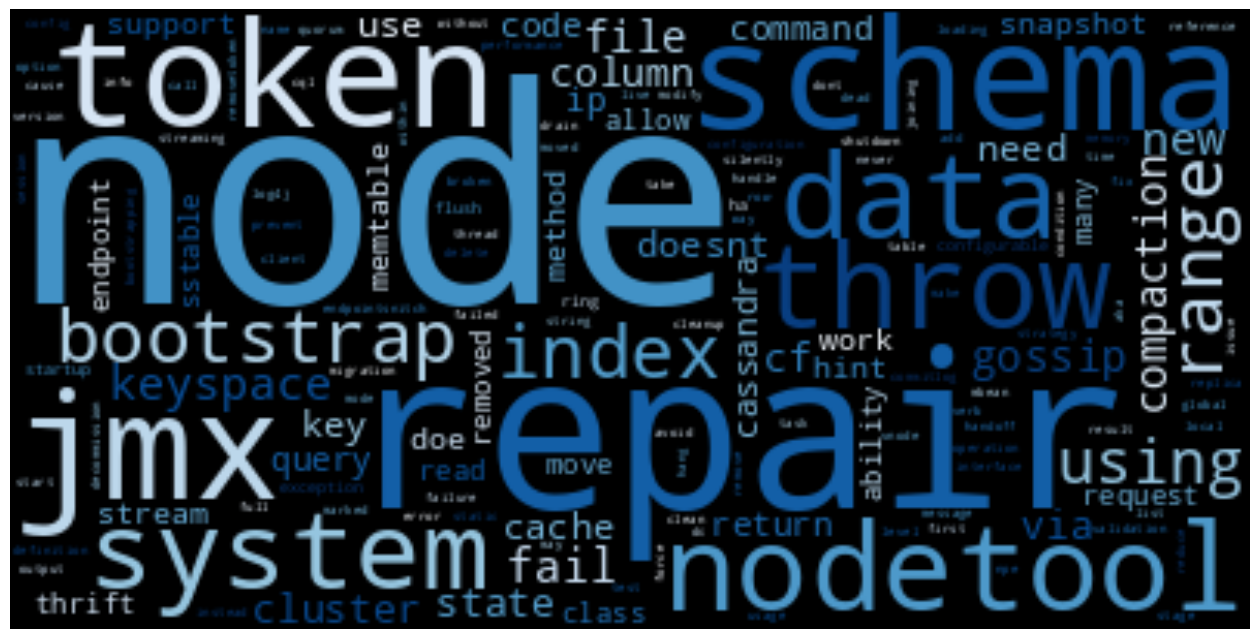

In [ ]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap = 'Blues').generate(texto_limpo_summary_storageservice)
plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Gera nuvem de palavras para Description

In [ ]:
texto_limpo_description_com_storageservice = clean(texto_description_com_storageservice)
len(texto_limpo_description_com_storageservice)

278561

### Nuvem de palavras dos "description" dos issues que possuem  o arquivo 'StorageService.java'

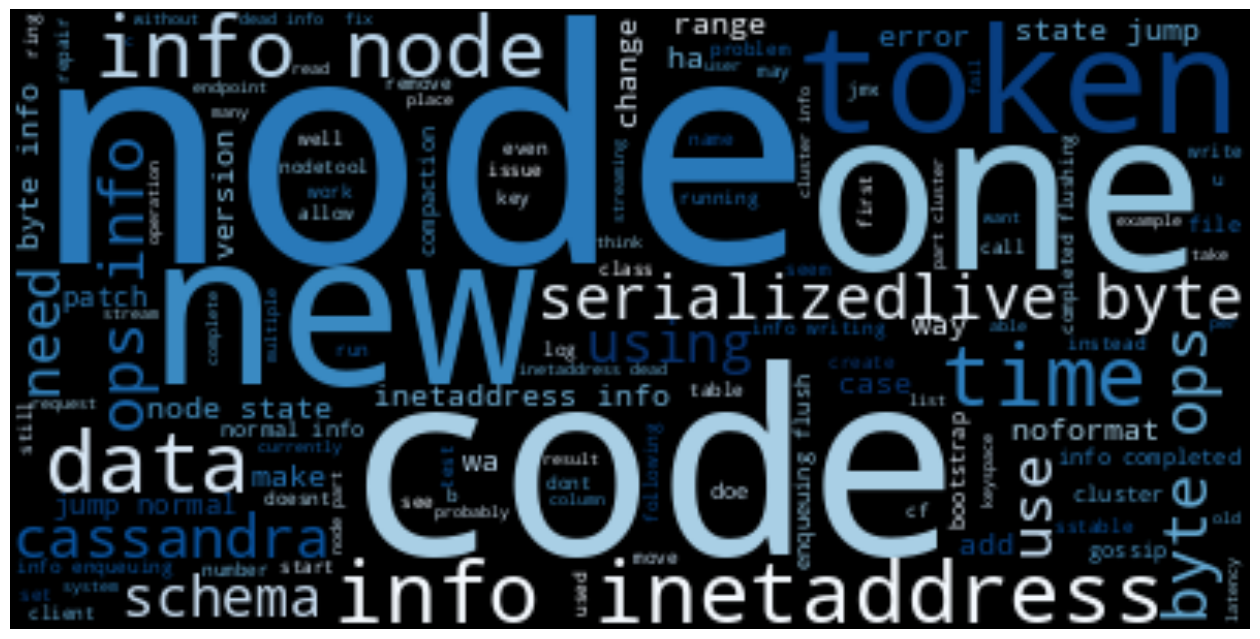

In [ ]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap = 'Blues').generate(texto_limpo_description_com_storageservice)
plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Gera numve de palavaras para Comments

In [ ]:
texto_limpo_comments_com_storageservice = clean(texto_comments_com_storageservice)
len(texto_limpo_comments_com_storageservice)

2086236

### Nuvem de palavras dos "comments" dos issues que possuem  o arquivo 'StorageService.java'

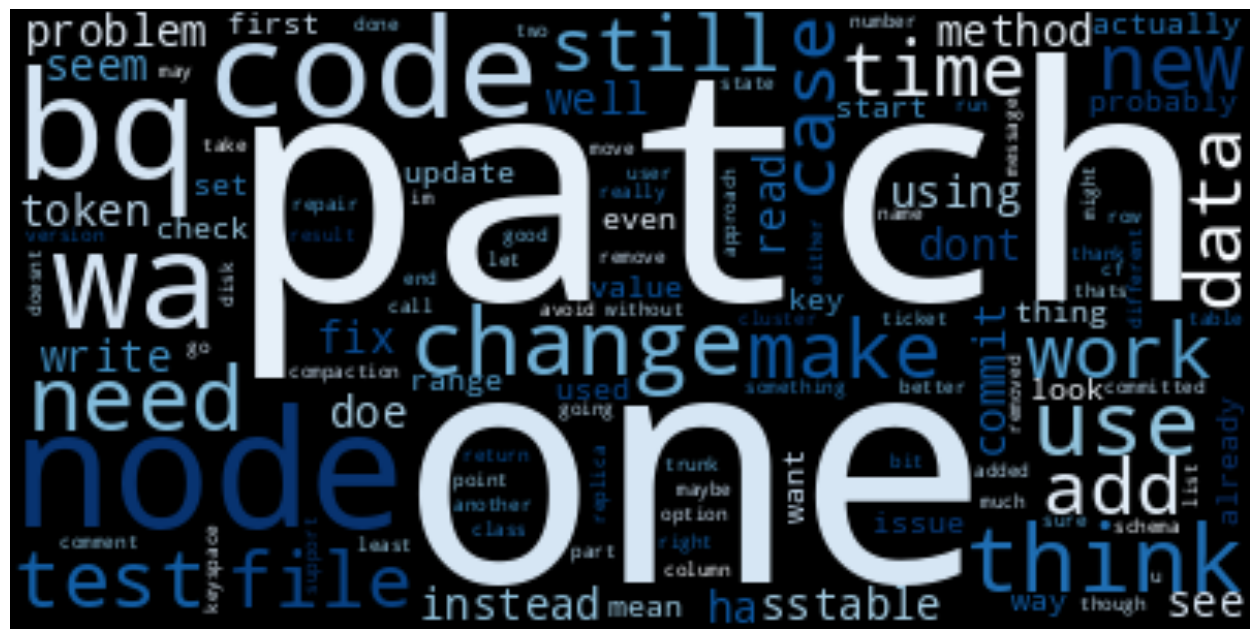

In [ ]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap = 'Blues').generate(texto_limpo_comments_com_storageservice)
plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()